# A Comparative Analysis of Underwater Image Enhancement Techniques

Tuğçe Kızıltepe - 21946352
Sümeyye Meryem Taşyürek - 21827871

This is our course project for BBM444 Fundamentals of Computational Photography Course.

Underwater imaging is critical for various applications, including marine biology and underwater exploration. However, underwater images often suffer from color distortion, contrast reduction, and detail loss due to the scattering and absorption of light by water. To address these challenges, various image enhancement techniques have been proposed, such as deep learning-based methods, physical models, and specific enhancement techniques. In this paper, we will perform a comparative analysis of these techniques using the widely used UIEB benchmark dataset. We evaluate their effectiveness in improving the visual quality of underwater images and provide insights into their limitations. We expect that deep learning-based methods generally outperform other techniques in terms of objective and subjective quality measures. However, physical models and specific enhancement techniques can still provide valuable improvements for certain types of images. This research can help researchers and practitioners choose appropriate methods for underwater image enhancement and inspire further developments in this field.

## Setting Up

In [2]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.3 MB/s eta 0:00:00


In [12]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import laplace
import scipy
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from skimage import exposure
from skimage import io
from PIL import Image
import torchvision.transforms.functional as F
from torchmetrics.functional import (
    structural_similarity_index_measure,
    peak_signal_noise_ratio,
)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATASET_PATH = "/content/drive/MyDrive/BBM444/data"  
RAW_PATH = os.path.join(DATASET_PATH, "raw-890")
REF_PATH = os.path.join(DATASET_PATH, "reference-890")

## Dataset

Show an image from the dataset

Image shape : (537, 791, 3)


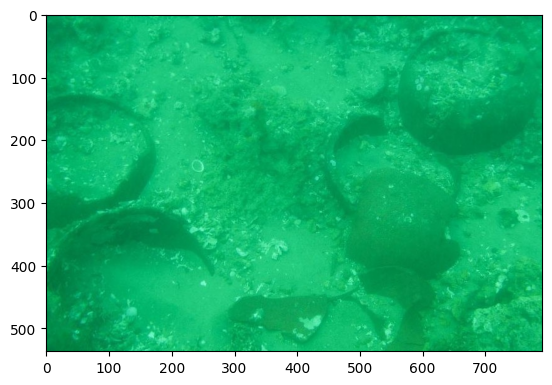

In [6]:
image = cv2.imread(os.path.join(RAW_PATH, "18_img_.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image shape :", image.shape )
plt.imshow(image)
plt.show()


As you can see, the image is in shades of green.

Image shape : (480, 640, 3)


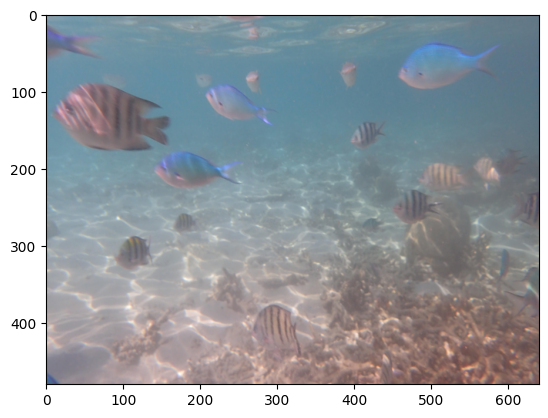

In [7]:
image = cv2.imread(os.path.join(RAW_PATH, "22_img_.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image shape :", image.shape )
plt.imshow(image)
plt.show()

As you can see above, there is a haze in the image. As you can see in the examples, we will examine the techniques presented to eliminate these problems.

## Single Image Haze Removal Using Dark Channel Prior[1]
Steps of the algorithm:
1. Compute the dark channel prior of the input hazy image.
2. Estimate the global atmospheric light in the input image.
3. Compute the transmission map of the input image using the dark channel prior and atmo-
spheric light.
4. Remove the haze from the input image using the estimated transmission map and atmospheric light.
5. Clip the pixel values of the output image to the range of [0, 255].

In [ ]:
patch_size = (10, 10)
omega = 0.9
rho = 0.12
sigma_s , sigma_r = 5, 0.05
lamb = 1e-4
beta = 0.01

In [ ]:
from numpy.lib.stride_tricks import as_strided
def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)

def compute_laplacian(img, mask=None, eps=10**(-7), win_rad=1):
    """Computes Matting Laplacian for a given image.

    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(np.bool_)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3))

    X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu))

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
    return L

In [ ]:
def dark_channel_prior_dehaze(image):
    """
    This function is used for dehazing an image.
    It removes the haze using dark channel prior technique

    :param image: numpy.ndarray
    :return: numpy.ndarray
    """
    # Compute the dark channel prior of the input hazy image.
    kernel = np.ones(patch_size, dtype=np.uint8)
    dark_channel = cv2.erode(np.min(image, axis=2), kernel, iterations=1).astype(np.uint8)

    plt.title("Dark channel")
    plt.imshow(dark_channel, cmap='gray')
    plt.show()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # We first pick the top 0.1 percent brightest pixels in the dark channel
    top_k = 0.01 * dark_channel.shape[0] * dark_channel.shape[1]

    # It returns unique values and their counts
    keys, nums = np.unique(dark_channel, return_counts=True)
    counter = {k: v for k, v in zip(keys, nums)}

    # Among these pixels, the pixels with highest intensity
    # in the input image I are selected as the atmospheric light.
    accum = 0
    candidate = 255
    while candidate >= 0:
        if candidate in counter:
            accum += counter[candidate]
            if accum >= top_k:
                break
        candidate -= 1
    
    # Estimate the global atmospheric light in the input image.
    arg_A = np.argwhere(gray_image == np.max(gray_image[dark_channel >= candidate]))
    atmospheric_light = image[arg_A[0, 0], arg_A[0, 1], :]


    # Compute the transmission map of the input image using 
    # the dark channel prior and atmospheric light.
    image_div_atmos = np.zeros(image.shape, dtype=np.float64)
    for i in range(3):
        image_div_atmos[:, :, i] = image[:, :, i] / atmospheric_light[i]
        
    transmission_map = 1 - omega * cv2.erode(np.min(image_div_atmos, axis=2), kernel, iterations=1)
    plt.title("Transmission Map Before Soft Matting")
    plt.imshow(transmission_map, cmap='gray')
    plt.show()
    # Refine transmission map
    # calculate prior confidence 
    prior_confidence = lamb * np.ones(transmission_map.shape, dtype=np.float64)
    # compute laplacian
    # print("Before laplacian")
    laplacian = compute_laplacian(image)
    print(laplacian.shape)
    # compute confidence
    confidence = scipy.sparse.diags(prior_confidence.ravel())
    print(confidence.shape)
    print("Before solution")
    solution = scipy.sparse.linalg.spsolve(
        laplacian + confidence,
        transmission_map.ravel() * prior_confidence.ravel()
    )
    print("After solution")
    soft_matted_image = np.minimum(np.maximum(solution.reshape(transmission_map.shape), 0), 1)
    refined_transmission_map = cv2.bilateralFilter(soft_matted_image.astype(np.float32), 0, sigma_s, sigma_r)
    refined_transmission_map = np.clip(refined_transmission_map, 0, 1)
    
    # Remove the haze from the input image using the estimated transmission map and atmospheric light.
    output = np.zeros(image.shape, dtype=np.float64)
    for i in range(3):
        output[:, :, i] = (output[:, :, i] - atmospheric_light[i]) / np.maximum(refined_transmission_map, 0.1) + atmospheric_light[i]
    # Clip the pixel values of the output image to the range of [0, 255]
    output = np.clip(output, 0, 255).astype(np.uint8)

    # Calculate scene depth

    depth = -np.log(refined_transmission_map + 1e-8) / beta
    depth_map = np.clip(depth, 0, 255).astype(np.uint8)
    depth_map = cv2.applyColorMap(depth_map, 11)

    return output, refined_transmission_map, depth_map



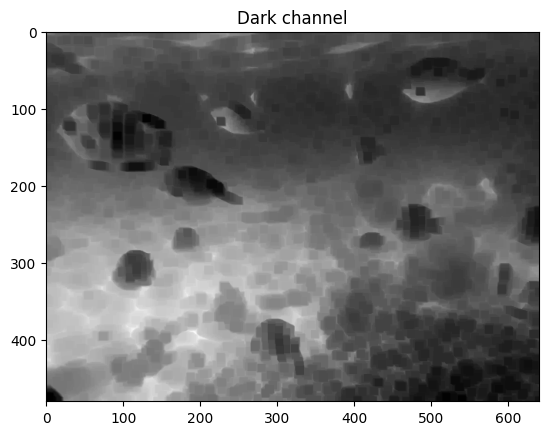

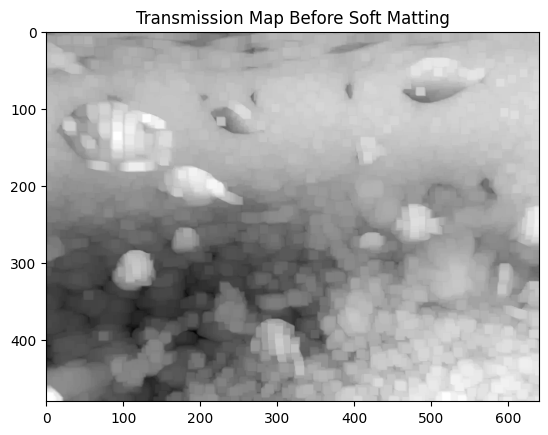

(307200, 307200)
(307200, 307200)
Before solution
After solution


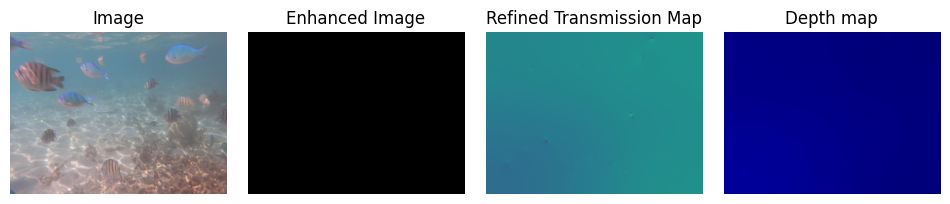

In [ ]:
output, refined_transmission_map, depth_map = dark_channel_prior_dehaze(image)
# create a figure
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(output)
axes[1].axis('off')
axes[1].set_title('Enhanced Image')

axes[2].imshow(refined_transmission_map)
axes[2].axis('off')
axes[2].set_title('Refined Transmission Map')

axes[3].imshow(depth_map)
axes[3].axis('off')
axes[3].set_title('Depth map')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# show the figure
plt.show()


## Water-Net[2]
This is a CNN model trained by the UIEB dataset. A gated fusion network called Water-Net fuses the inputs and the predicted confidence maps to produce the improved outcome. The Feature Transformation Units (FTUs) first convert the inputs to the refined inputs before predicting the confidence maps. Finally, by combining the improved inputs and the corresponding confidence maps, the improved result is obtained.

By individually applying White Balance (WB), Histogram Equalization (HE), and Gamma Correction (GC) algorithms to an underwater image, we produce three inputs. In particular, the WB algorithm is used to remove color casts, while the HE and GC algorithms work to boost contrast and brighten dark areas, respectively.


![alt text](assets\Screenshot_1.png)
You can see the Water-Net architecture above. 



In [7]:
def gray_world_assumption(img):
  """
  This function is implementation of gray world assumption automatic white balancing algorithm.
  :param img: numpy.ndarray
  :return: white balanced image after applying gray world assumption automatic white balancing
  """
  red_channel_max = np.mean(img[:, :, 0]) # average value of red channel
  green_channel_max = np.mean(img[:, :, 1]) # average value of green channel
  blue_channel_max = np.mean(img[:, :, 2]) # average value of blue channel
  # define matrix that is stated in lecture notes
  matrix = np.array([[green_channel_max / red_channel_max, 0 , 0],
                     [0, 1, 0],
                     [0, 0, green_channel_max / blue_channel_max ]])
  
  # dot product matrix with the image
  img_white_balanced = np.transpose(np.dot(matrix, np.transpose(img, axes=[0, 2, 1])), axes = [1, 2, 0])
  return img_white_balanced

def gamma_correction(image):
    return np.clip(255 * (np.power(image / 255, 0.7)).astype(np.uint8), 0, 255)

def histeq(image):
    # convert image to LAB color space
    im_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # apply histogram equalization to the L channel
    im_lab[:,:,0] = exposure.equalize_hist(im_lab[:,:,0])
    
    # convert the LAB image back to RGB color space
    im_he_rgb = cv2.cvtColor(im_lab, cv2.COLOR_LAB2RGB)
    
    return im_he_rgb


In [21]:
class UIEBDataset(torch.utils.data.Dataset):
    """UIEBDataset."""

    def __init__(
        self,
        raw_path,
        ref_path,
        transform=None,
    ):

        self.raw_image_files = sorted(glob.glob(RAW_PATH + "/*"))
        self.ref_image_files = sorted(glob.glob(REF_PATH + "/*"))
        if transform is not None:
            self.transform = transform
        self.raw_path = raw_path
        self.ref_path = ref_path

    def __len__(self):
        return len(self.raw_image_files)

    def __getitem__(self, idx):
        # Load image
        raw_image = cv2.imread(self.raw_image_files[idx])
        ref_image = cv2.imread(self.ref_image_files[idx])
        # # reshape image
        # w, h = int(raw_image.shape[0] / 32) * 32, int(raw_image.shape[1] / 32) * 32
        # raw_image = cv2.resize(raw_image, (w, h))
        # ref_image = cv2.resize(ref_image, (w, h))

        # convert BGR to RGB
        raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
        ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            raw_image = transform(raw_image)
            ref_image = transform(ref_image)

        raw_image = raw_image.permute(1, 2, 0)
        ref_image = ref_image.permute(1, 2, 0)

        # Preprocessing transforms
        white_balanced = gray_world_assumption(np.array(raw_image))
        gamma_corrected = gamma_correction(np.array(raw_image))
        he = histeq(np.array(raw_image))

        # scale 0 and 1
        raw_image = raw_image.permute(2, 1, 0).double() / 255 
        wb = torch.from_numpy(white_balanced).permute(2, 1, 0).double() / 255 
        gc = torch.from_numpy(gamma_corrected).permute(2, 1, 0).double() / 255 
        he = torch.from_numpy(he).permute(2, 1, 0).double() / 255 
        ref_image = ref_image.permute(2, 1, 0).double() / 255 

      
        return raw_image, wb, he, gc, ref_image

In [22]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((112, 112))
                                ])

In [23]:
# transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
#                                 transforms.RandomVerticalFlip(p=0.5),
#                                 transforms.RandomRotation(90),
#                                 transforms.Resize((112, 112))
#                                 ])

In [24]:
dataset = UIEBDataset(
        RAW_PATH,
        REF_PATH,
        transform
    )
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)


The implementation of the WaterNet can be seen below.

In [34]:
#@title

class ConfidenceMapGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=12, out_channels=128, kernel_size=7, dilation=1, padding="same"
        )
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=5, dilation=1, padding="same"
        )
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, dilation=1, padding="same"
        )
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=64, kernel_size=1, dilation=1, padding="same"
        )
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=7, dilation=1, padding="same"
        )
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=5, dilation=1, padding="same"
        )
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, dilation=1, padding="same"
        )
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(
            in_channels=64, out_channels=3, kernel_size=3, dilation=1, padding="same"
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, wb, ce, gc):
        out = torch.cat([x, wb, ce, gc], dim=1)
        out = self.relu1(self.conv1(out))
        out = self.relu2(self.conv2(out))
        out = self.relu3(self.conv3(out))
        out = self.relu4(self.conv4(out))
        out = self.relu5(self.conv5(out))
        out = self.relu6(self.conv6(out))
        out = self.relu7(self.conv7(out))
        out = self.sigmoid(self.conv8(out))
        out1, out2, out3 = torch.split(out, [1, 1, 1], dim=1)
        return out1, out2, out3


class Refiner(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=6, out_channels=32, kernel_size=7, dilation=1, padding="same"
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=5, dilation=1, padding="same"
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=3, kernel_size=3, dilation=1, padding="same"
        )
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()

    def forward(self, x, xbar):
        out = torch.cat([x, xbar], dim=1)
        out = self.relu1(self.conv1(out))
        out = self.relu2(self.conv2(out))
        out = self.relu3(self.conv3(out))
        return out


class WaterNet(nn.Module):
    """
    waternet = WaterNet()
    in = torch.randn(16, 3, 112, 112)
    waternet_out = waternet(in, in, in, in)
    waternet_out.shape
    # torch.Size([16, 3, 112, 112])
    """

    def __init__(self):
        super().__init__()
        self.cmg = ConfidenceMapGenerator()
        self.wb_refiner = Refiner()
        self.ce_refiner = Refiner()
        self.gc_refiner = Refiner()

    def forward(self, x, wb, ce, gc):
        wb_cm, ce_cm, gc_cm = self.cmg(x, wb, ce, gc)
        refined_wb = self.wb_refiner(x, wb)
        refined_ce = self.ce_refiner(x, ce)
        refined_gc = self.gc_refiner(x, gc)
        return (
            torch.mul(refined_wb, wb_cm)
            + torch.mul(refined_ce, ce_cm)
            + torch.mul(refined_gc, gc_cm)
        )

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# initialize model
model = WaterNet().double()
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

num_epochs = 30

ssim_scores_train = []
psnr_scores_train = []
mean_scores_train = []

ssim_scores_val = []
psnr_scores_val = []
mean_scores_val = []

for i in range(num_epochs):
  model.train()
  ssim_scores_epoch = []
  psnr_scores_epoch = []
  mse_scores_epoch = []
  for image, wb, he, gc, ref in train_dataloader:
    image = image.to(device)
    wb = wb.to(device)
    he = he.to(device)
    gc = gc.to(device)
    ref = ref.to(device)
    out = model(image, wb, he, gc)
    # calculate evaluation metrics
    # print("----------")
    # print(out)
    ssim = structural_similarity_index_measure(preds=out, target=ref)
    psnr = peak_signal_noise_ratio(preds=out, target=ref, data_range=1-0)
    mse = torch.mean(torch.square(255 * (out - ref)))
    ssim_scores_epoch.append(ssim.item()) 
    psnr_scores_epoch.append(psnr.item()) 
    mse_scores_epoch.append(mse.item())

    # Composite loss
    loss = mse
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
  # calculate average scores
  avg_ssim = sum(ssim_scores_epoch) / len(ssim_scores_epoch)
  avg_psnr = sum(psnr_scores_epoch) / len(psnr_scores_epoch)
  avg_mse = sum(mse_scores_epoch) / len(mse_scores_epoch)

  print(f"Training: Epoch: {i}, SSIM Score: {avg_ssim}, PSNR Score: {avg_psnr}, MSE: {avg_mse}")
  ssim_scores_train.append(avg_ssim)
  psnr_scores_train.append(avg_psnr)
  mean_scores_train.append(avg_mse)

  # evaluation one epoch        
  model.eval()
  ssim_scores_epoch = []
  psnr_scores_epoch = []
  mse_scores_epoch = []
  with torch.no_grad():
    for image, wb, he, gc, ref in val_dataloader:
      image = image.to(device)
      wb = wb.to(device)
      he = he.to(device)
      gc = gc.to(device)
      ref = ref.to(device)
      out = model(image, wb, he, gc)

      # calculate evaluation metrics
      ssim = structural_similarity_index_measure(preds=out, target=ref)
      psnr = peak_signal_noise_ratio(preds=out, target=ref, data_range=1 - 0)
      ssim_scores_epoch.append(ssim.item()) 
      psnr_scores_epoch.append(psnr.item()) 
      mse_scores_epoch.append(torch.mean(torch.square(255 * (out - ref))).item())

  # calculate average scores
  avg_ssim = sum(ssim_scores_epoch) / len(ssim_scores_epoch)
  avg_psnr = sum(psnr_scores_epoch) / len(psnr_scores_epoch)
  avg_mse= sum(mse_scores_epoch) / len(mse_scores_epoch)

  ssim_scores_val.append(avg_ssim)
  psnr_scores_val.append(avg_psnr)
  mean_scores_val.append(avg_mse)
  print(f"Validation: Epoch: {i}, SSIM Score: {avg_ssim}, PSNR Score: {avg_psnr}, MSE: {avg_mse}")

Device:  cuda
Training: Epoch: 0, SSIM Score: 0.029637984330896164, PSNR Score: 52.304485181357904, MSE: 4.131026592751635
Validation: Epoch: 0, SSIM Score: 0.0036592574715395153, PSNR Score: 54.079599697996095, MSE: 0.2544175576381776
Training: Epoch: 1, SSIM Score: 0.006934882926859241, PSNR Score: 54.05662714247401, MSE: 0.2562602959571888
Validation: Epoch: 1, SSIM Score: 0.0036592574715395153, PSNR Score: 54.079599697996095, MSE: 0.2544175576381776
Training: Epoch: 2, SSIM Score: 0.006934882926859241, PSNR Score: 54.05662714247401, MSE: 0.2562602959571888
Validation: Epoch: 2, SSIM Score: 0.0036592574715395153, PSNR Score: 54.079599697996095, MSE: 0.2544175576381776
Training: Epoch: 3, SSIM Score: 0.006934882926859241, PSNR Score: 54.05662714247401, MSE: 0.2562602959571888
Validation: Epoch: 3, SSIM Score: 0.0036592574715395153, PSNR Score: 54.079599697996095, MSE: 0.2544175576381776
Training: Epoch: 4, SSIM Score: 0.006934882926859241, PSNR Score: 54.05662714247401, MSE: 0.256260

In [ ]:
torch.save(model.state_dict(), "last-model.pt")

## Traditional Image Processing Technique[3, 4]
The approach used to enhance underwater images includes color correction, white balancing, contrast enhancement, unsharp masking, and fusion. First, the images are color corrected by compensating for the degradation of the red and blue channels, followed by white balancing using the Gray World algorithm. Then, the contrast of the color-corrected image is enhanced using global histogram equalization, and the image is sharpened using unsharp masking. Finally, two techniques are used for image fusion: averaging-based fusion and PCA-based fusion. The PCA-based fusion involves flattening the components of both images into a column vector, finding the mean, covariance matrix, and eigenvectors of the concatenated matrix, and obtaining the coefficients for each channel for both images to obtain the fused image.


#### Setting Up

In [127]:
from PIL import ImageFilter

In [59]:
# Load the example image with greenish appearance
image = Image.open(os.path.join(RAW_PATH, "910_img_.png")) # 
# Load reference the image
reference = Image.open(os.path.join(REF_PATH, "910_img_.png"))

In [33]:
def split_channels(image):
    # Convert image to numpy array
    image_array = np.array(image)

    # Split the image array into color channels
    red_channel = image_array.copy()
    red_channel[:, :, (1, 2)] = 0  # Set green and blue channels to 0

    green_channel = image_array.copy()
    green_channel[:, :, (0, 2)] = 0  # Set red and blue channels to 0

    blue_channel = image_array.copy()
    blue_channel[:, :, (0, 1)] = 0  # Set red and green channels to 0

    # Convert arrays back to images
    red_channel = Image.fromarray(red_channel)
    green_channel = Image.fromarray(green_channel)
    blue_channel = Image.fromarray(blue_channel)

    return red_channel, green_channel, blue_channel

In [185]:
def plot_histogram(image):
    # Split the R, G and B channels
    R, G, B = image.split()
    
    # Plot the histigrams
    plt.figure(figsize = (20, 10))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title("Histogram of image")
    plt.plot(R.histogram(), color='red') 
    plt.plot(G.histogram(), color='green')
    plt.plot(B.histogram(), color='blue')
    plt.show()

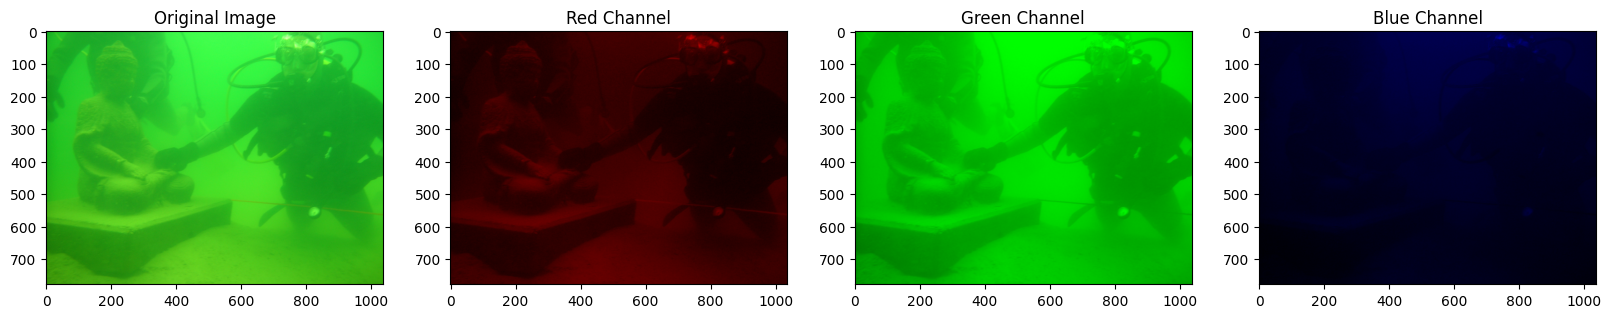

In [35]:
R, G, B = split_channels(image)

# Plot R, G and B components
plt.figure(figsize = (20, 20))  
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(1, 4, 2)
plt.title("Red Channel")
plt.imshow(R)
plt.subplot(1, 4, 3)
plt.title("Green Channel")
plt.imshow(G) 
plt.subplot(1, 4, 4)
plt.title("Blue Channel")
plt.imshow(B) 
plt.show()

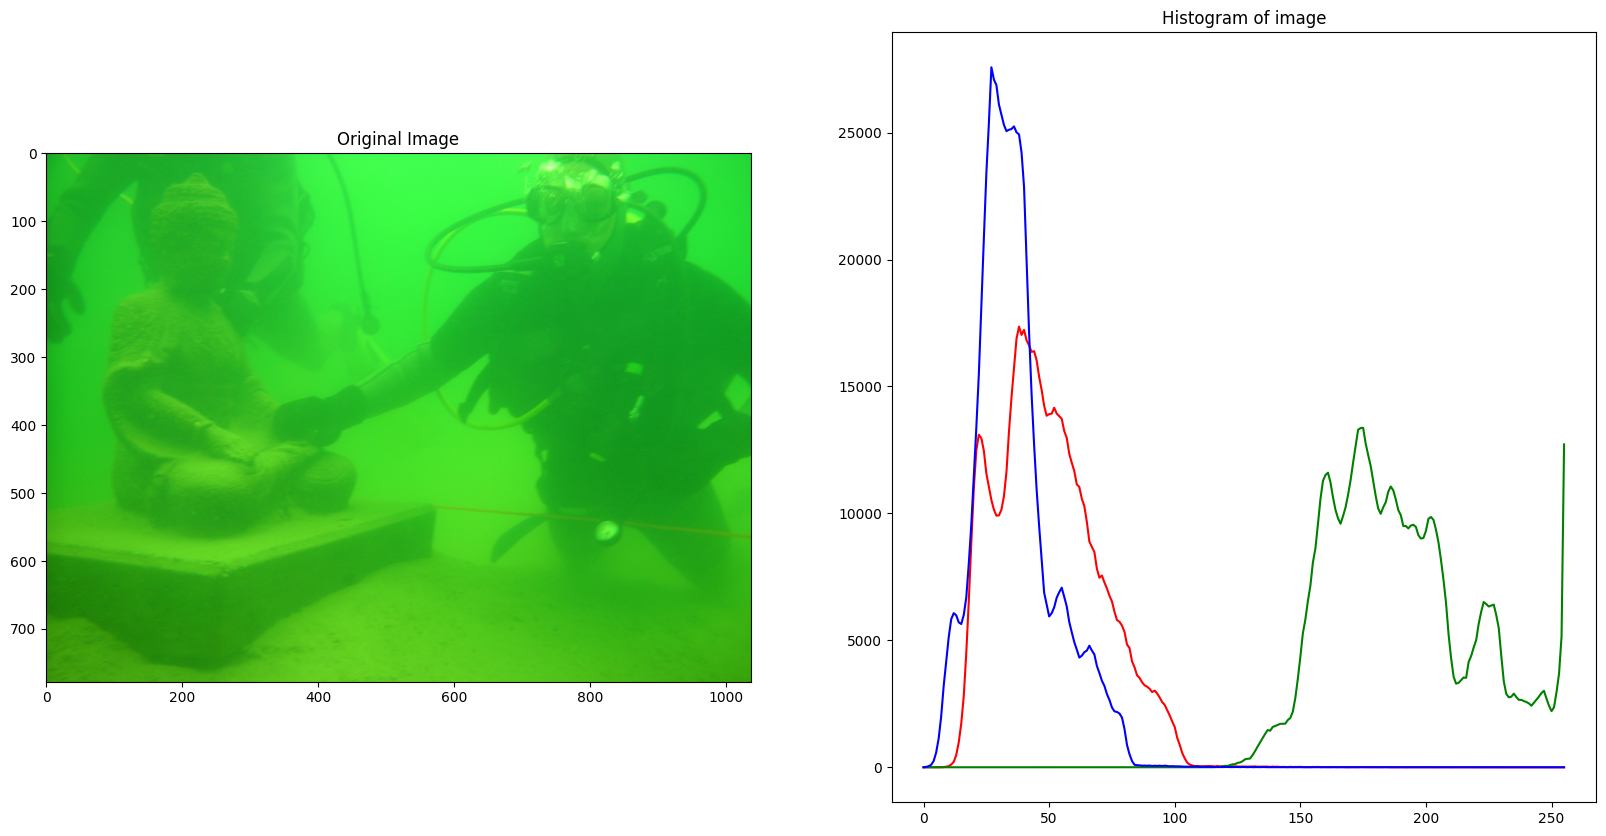

In [36]:
plot_histogram(image)

We have observered that blue and red channel is usually concentrated on the left side of the histogram and in cases of images with greenish appearance. To enhance this image and more we will define some steps as functions and apply them to our dataset.

#### Compensating R and B(when required) channel

In [168]:
def compensate_RB(image, flag):
    # Splitting the image into R, G, and B components
    red_channel, green_channel, blue_channel = image.split()

    # Get maximum and minimum pixel values
    min_red, max_red = red_channel.getextrema()
    min_green, max_green = green_channel.getextrema()
    min_blue, max_blue = blue_channel.getextrema()

    # Convert channels to arrays
    red = np.array(red_channel, np.float64)
    green = np.array(green_channel, np.float64)
    blue = np.array(blue_channel, np.float64)

    width, height = image.size

    # Normalizing the pixel values to the range (0, 1)
    red = (red - min_red) / (max_red - min_red)
    green = (green - min_green) / (max_green - min_green)
    blue = (blue - min_blue) / (max_blue - min_blue)

    # Calculate mean of each channel
    mean_red = np.mean(red)
    mean_green = np.mean(green)
    mean_blue = np.mean(blue)

    # Compensate Red and Blue channel
    if flag == 0:
        red = ((red + (mean_green - mean_red) * (1 - red) * green) * max_red).astype(int)
        blue = ((blue + (mean_green - mean_blue) * (1 - blue) * green) * max_blue).astype(int)

        # Scale the pixel values back to the original range for green channel
        green = (green * max_green).astype(int)

    # Compensate Red channel
    if flag == 1:
        red = ((red + (mean_green - mean_red) * (1 - red) * green) * max_red).astype(int)

        # Scale the pixel values back to the original range for blue and green channels
        blue = (blue * max_blue).astype(int)
        green = (green * max_green).astype(int)

    # Create the compensated image
    compensated_image = np.zeros((height, width, 3), dtype="uint8")
    compensated_image[:, :, 0] = red
    compensated_image[:, :, 1] = green
    compensated_image[:, :, 2] = blue

    return Image.fromarray(compensated_image)

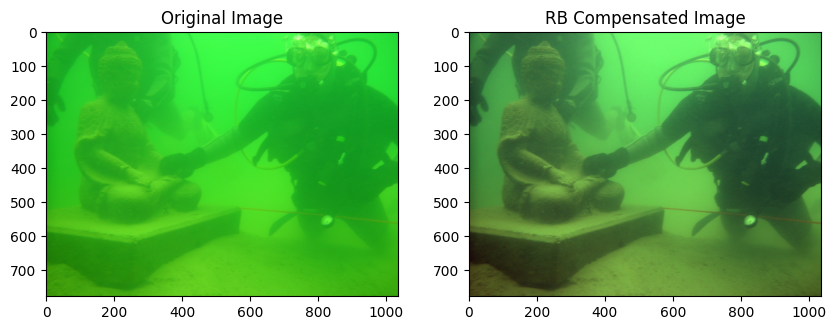

In [169]:
compensated_img = compensate_RB(image, 0)

# Plotting the compensated image
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("RB Compensated Image")
plt.imshow(compensated_img) 
plt.show()

#### White balancing using Gray World Assumption

In [173]:
def gray_world(image):
    # Splitting the image into R, G, and B components
    red_channel, green_channel, blue_channel = image.split()

    # Convert the image to grayscale
    grayscale_image = image.convert('L')

    # Convert channels to arrays
    red = np.array(red_channel, np.float64)
    green = np.array(green_channel, np.float64)
    blue = np.array(blue_channel, np.float64)
    gray = np.array(grayscale_image, np.float64)

    width, height = image.size

    # Get mean value of pixels in each channel
    mean_red = np.mean(red)
    mean_green = np.mean(green)
    mean_blue = np.mean(blue)
    mean_gray = np.mean(gray)

    # Gray World Algorithm
    red = (red * mean_gray / mean_red).astype(int)
    green = (green * mean_gray / mean_green).astype(int)
    blue = (blue * mean_gray / mean_blue).astype(int)

    # Create the white balanced image
    whitebalanced_image = np.zeros((height, width, 3), dtype="uint8")
    whitebalanced_image[:, :, 0] = red
    whitebalanced_image[:, :, 1] = green
    whitebalanced_image[:, :, 2] = blue

    return Image.fromarray(whitebalanced_image)

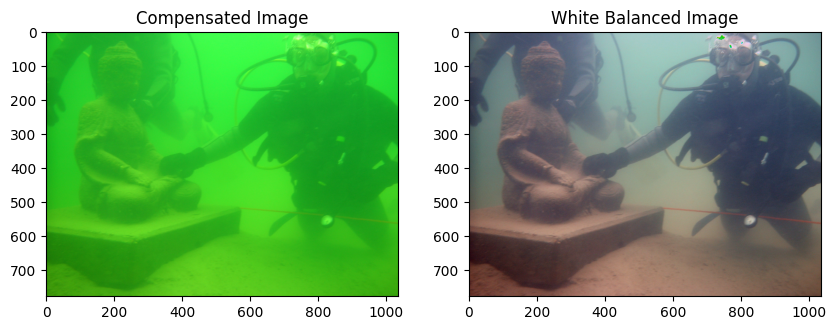

In [175]:
balanced_img = gray_world(compensated_img)
# Plotting the compensated image
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.title("Compensated Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("White Balanced Image")
plt.imshow(balanced_img) 
plt.show() 

#### Image Sharpening Of White Balanced Image

In [176]:
def sharpen(white_balanced_image, original_image):
    # First find the smoothed image using Gaussian filter
    smoothed_image = white_balanced_image.filter(ImageFilter.GaussianBlur)
    
    # Convert images to arrays
    smoothed_array = np.array(smoothed_image, dtype=np.float64)
    white_balanced_array = np.array(white_balanced_image, dtype=np.float64)
    
    # Perform unsharp masking
    sharpened_array = 2 * white_balanced_array - smoothed_array
    
    # Clip the values to ensure they are within the valid range [0, 255]
    sharpened_array = np.clip(sharpened_array, 0, 255)
    
    # Convert the array back to image
    sharpened_image = Image.fromarray(sharpened_array.astype(np.uint8))
    
    return sharpened_image

In [177]:
sharpened_img = sharpen(balanced_img, image)

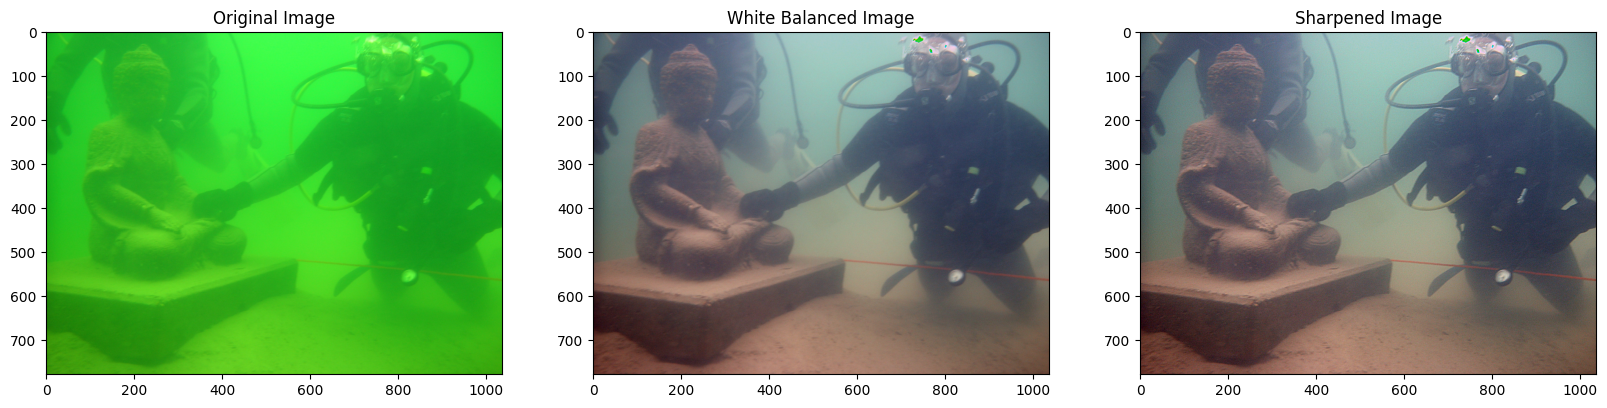

In [178]:
# Plotting the sharpened image
plt.figure(figsize = (20, 20))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.title("White Balanced Image")
plt.imshow(balanced_img)
plt.subplot(1, 3, 3)
plt.title("Sharpened Image")
plt.imshow(sharpened_img) 
plt.show()

#### Contrast enhancement of white balanced image by Global Histogram Equalization

In [179]:
def hsv_equalization(image):
    # Convert to HSV
    hsv_image = image.convert('HSV')
    
    # Splitting the Hue, Saturation, and Value components
    hue, saturation, value = hsv_image.split()
    
    # Perform equalization on Value component
    value_array = np.array(value)
    equalized_value = Image.fromarray(np.uint8(np.interp(value_array, (value_array.min(), value_array.max()), (0, 255))))
    
    width, height = image.size
    
    # Create the equalized image array
    equalized_img_array = np.zeros((height, width, 3), dtype="uint8")
    equalized_img_array[:, :, 0] = np.array(hue)
    equalized_img_array[:, :, 1] = np.array(saturation)
    equalized_img_array[:, :, 2] = np.array(equalized_value)
    
    # Convert the array to image
    equalized_hsv_image = Image.fromarray(equalized_img_array, 'HSV')
    
    # Convert to RGB
    equalized_rgb_image = equalized_hsv_image.convert('RGB')
    
    return equalized_rgb_image

In [180]:
contrastenhanced_img = hsv_equalization(balanced_img)

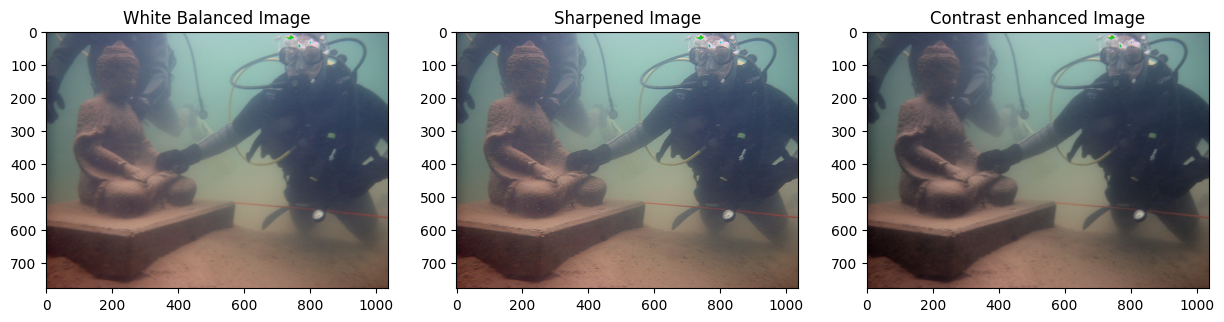

In [181]:
# Plot equalized image
plt.figure(figsize = (15, 15))
plt.subplot(1, 3, 1)
plt.title("White Balanced Image")
plt.imshow(balanced_img)
plt.subplot(1, 3, 2)
plt.title("Sharpened Image")
plt.imshow(sharpened_img)
plt.subplot(1, 3, 3)
plt.title("Contrast enhanced Image")
plt.imshow(contrastenhanced_img) 
plt.show()

#### Fusion of sharpened image and contrast enhanced image

In [112]:
# Using averaging method
def average_fusion(image1, image2):
    # Split the images into R, G, B channels
    image1_r, image1_g, image1_b = image1.split()
    image2_r, image2_g, image2_b = image2.split()
    
    # Convert channels to arrays
    image1_r = np.array(image1_r, dtype=np.float64)
    image1_g = np.array(image1_g, dtype=np.float64)
    image1_b = np.array(image1_b, dtype=np.float64)
    image2_r = np.array(image2_r, dtype=np.float64)
    image2_g = np.array(image2_g, dtype=np.float64)
    image2_b = np.array(image2_b, dtype=np.float64)
    
    # Perform fusion by averaging the pixel values
    fused_r = ((image1_r + image2_r) / 2).astype(np.uint8)
    fused_g = ((image1_g + image2_g) / 2).astype(np.uint8)
    fused_b = ((image1_b + image2_b) / 2).astype(np.uint8)
    
    # Create the fused image
    fused_image = Image.fromarray(np.dstack((fused_r, fused_g, fused_b)), 'RGB')
    
    return fused_image

In [113]:
averagefused_img = average_fusion(sharpened_img, contrastenhanced_img)

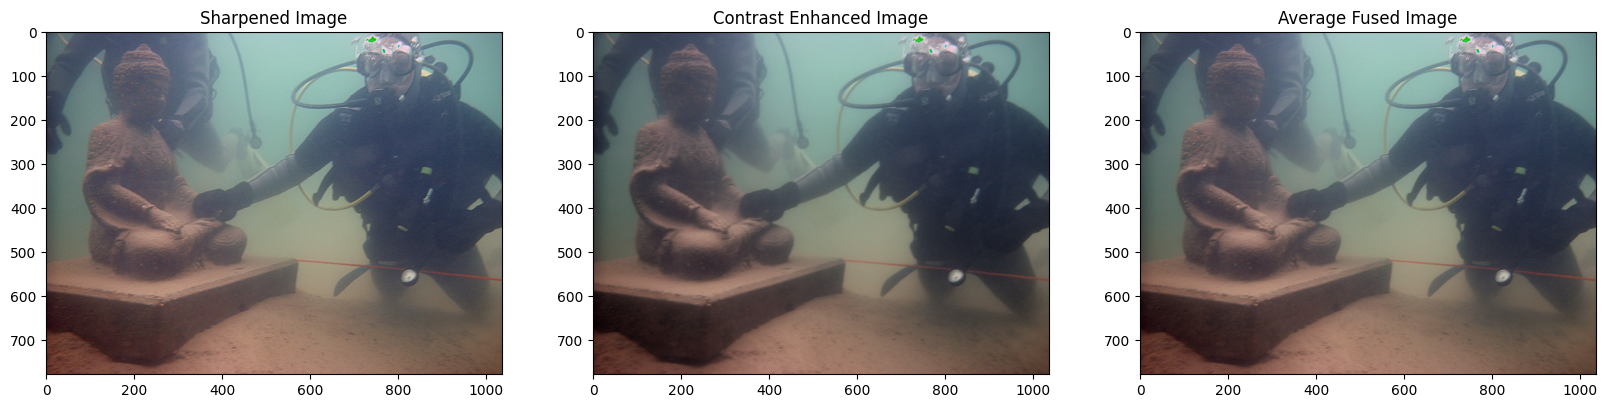

In [114]:
# Plot the fused image
plt.figure(figsize = (20, 20))
plt.subplot(1, 3, 1)
plt.title("Sharpened Image")
plt.imshow(sharpened_img)
plt.subplot(1, 3, 2)
plt.title("Contrast Enhanced Image")
plt.imshow(contrastenhanced_img)
plt.subplot(1, 3, 3)
plt.title("Average Fused Image")
plt.imshow(averagefused_img) 
plt.show()

#### Evaluation Mertics

In [142]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [160]:
def metrics(reference, fused, original):
  # Convert images to arrays
  reference = np.array(reference, np.float64)
  fused = np.array(fused, np.float64)
  original = np.array(original, np.float64)

  # Compute SSIM and PSNR for original
  ssim_1 = structural_similarity(reference, original, channel_axis=2)
  psnr_1 = peak_signal_noise_ratio(reference, original, data_range=255)

  # Compute SSIM and PSNR for for fused
  ssim_2 = structural_similarity(reference, fused, channel_axis=2)
  psnr_2 = peak_signal_noise_ratio(reference, fused, data_range=255)

  return ssim_1, psnr_1, ssim_2, psnr_2

In [161]:
ssim_1, psnr_1, ssim_2, psnr_2 = metrics(reference, averagefused_img, image)
print("SSIM & PSNR of Average fused image")
print("Reference vs Original-", "SSIM: ", ssim_1, "PSNR:", psnr_1)
print("Reference vs Fused-", "SSIM: ", ssim_2, "PSNR:", psnr_2)

SSIM & PSNR of Average fused image
Reference vs Original- SSIM:  0.3232325148259925 PSNR: 10.107983311659531
Reference vs Fused- SSIM:  0.7086767771569931 PSNR: 17.36285261211798


#### UnderWater Image Enhacement Function

In [189]:
# flag = 0 for Red, Blue Compensation via green channel
# flag = 1 for Red Compensation via green channel
def underwater_image_enhancement(image, refimage, flag):
    # Plotting histogram
    plot_histogram(image)
    # Compensate image based on flag
    compensated_img = compensate_RB(image, flag)
    # Apply gray world algorithm to complete color correction
    balanced_img = gray_world(compensated_img)
    # Plot histogram of color corrected image
    plot_histogram(balanced_img)
    # Perform contrast enhancement using global Histogram Equalization
    contrastenhanced_img = hsv_equalization(balanced_img)
    # Perform Unsharp Masking to sharpen the color corrected image
    sharpened_img=sharpen(contrastenhanced_img, image)
    # Perform avergaing-based fusion of sharpenend image & contrast enhanced image
    averagefused =  average_fusion(sharpened_img, contrastenhanced_img)
    # Plot the fused image
    plt.figure(figsize = (20, 20))
    plt.subplot(1, 3, 1)
    plt.title("Sharpened Image")
    plt.imshow(sharpened_img)
    plt.subplot(1, 3, 2)
    plt.title("Contrast Enhanced Image")
    plt.imshow(contrastenhanced_img)
    plt.subplot(1, 3, 3)
    plt.title("Average Fused Image")
    plt.imshow(averagefused_img) 
    plt.show()
    
    print()
    ssim_1, psnr_1, ssim_2, psnr_2 = metrics(reference, averagefused_img, image)
    print("SSIM & PSNR of Average fused image")
    print("Reference vs Original-", "SSIM: ", ssim_1, "PSNR:", psnr_1)
    print("Reference vs Enhanced-", "SSIM: ", ssim_2, "PSNR:", psnr_2)

    return averagefused_img

In [190]:
# Load the example image with greenish appearance
image = Image.open(os.path.join(RAW_PATH, "910_img_.png")) # 
# Load reference the image
reference = Image.open(os.path.join(REF_PATH, "910_img_.png"))

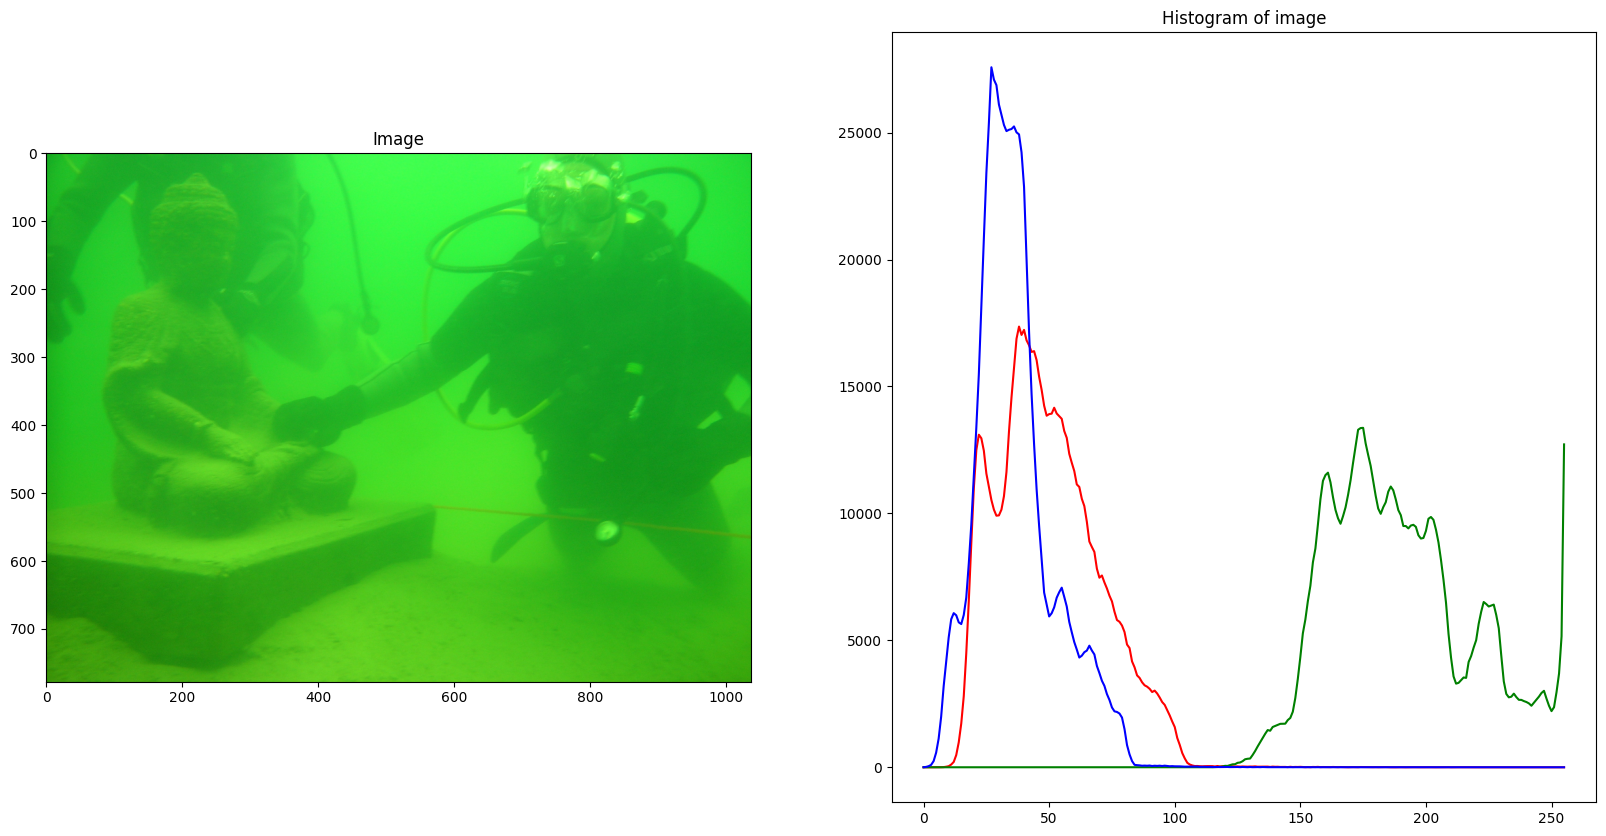

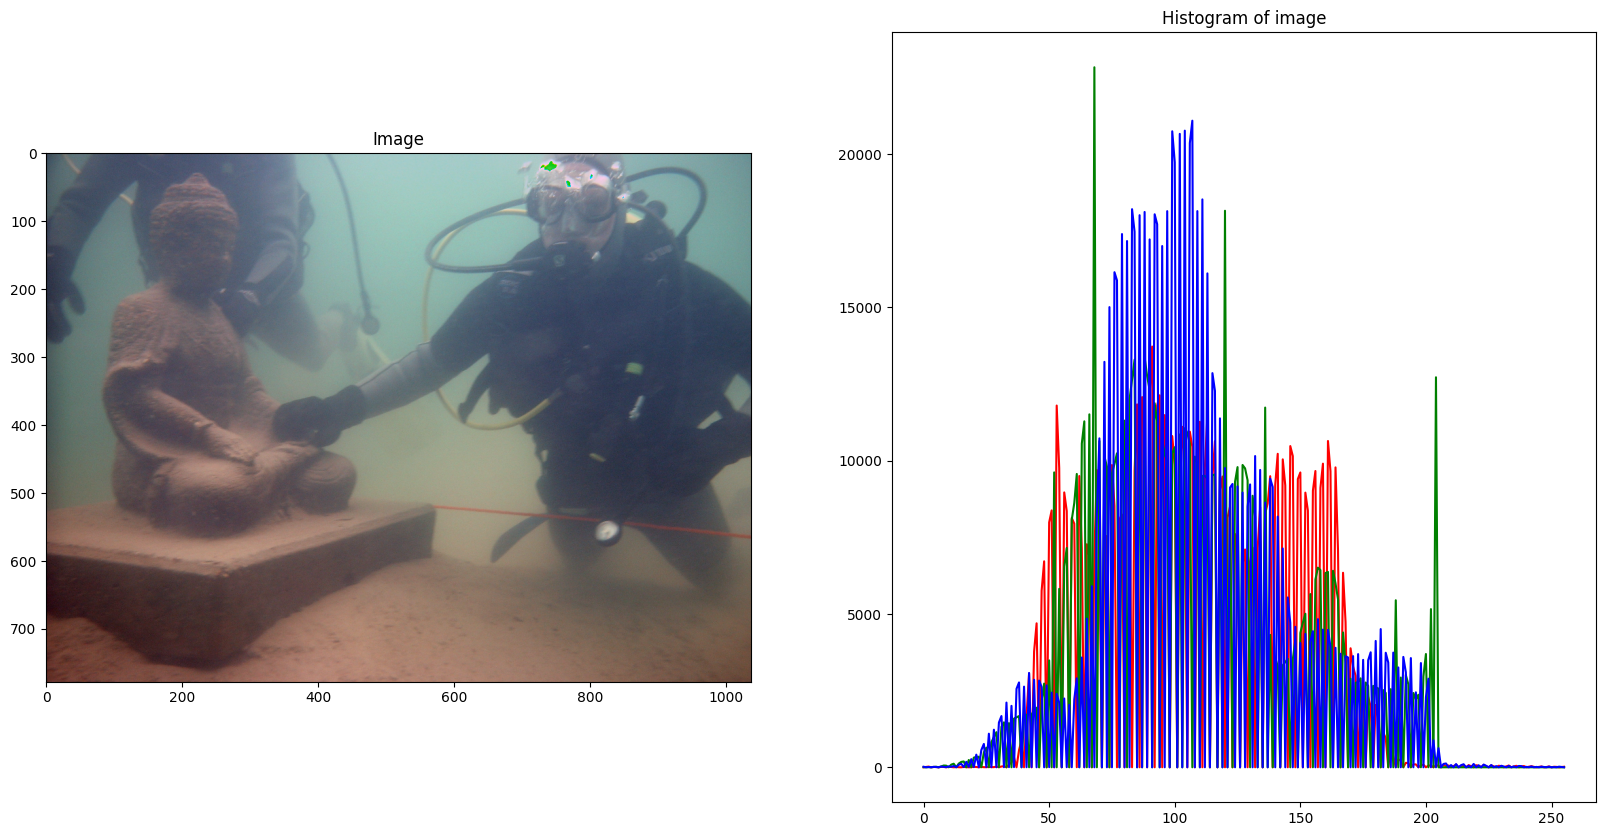

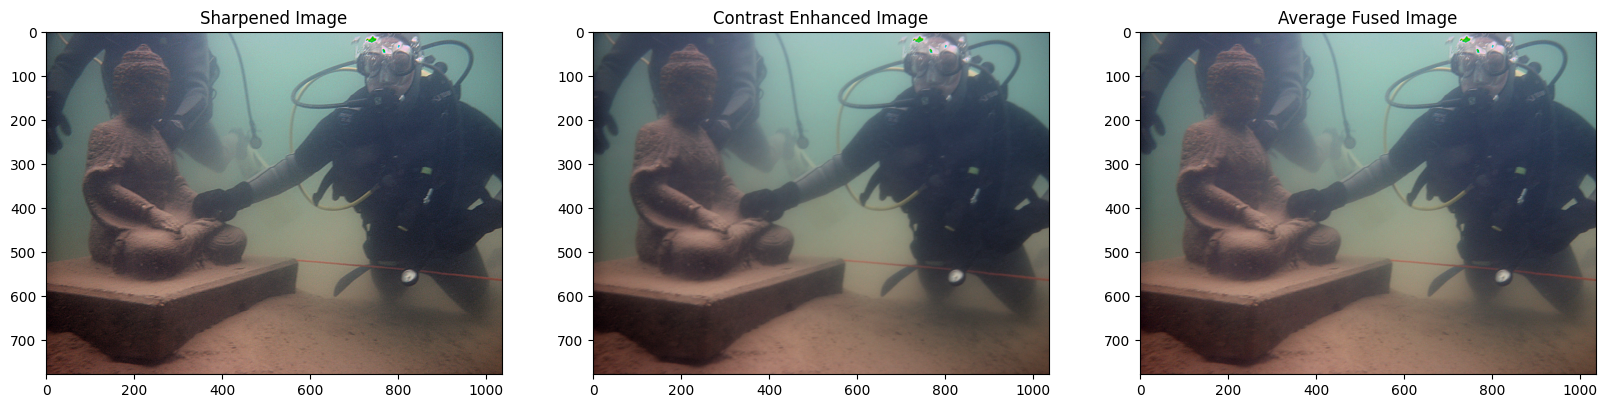


SSIM & PSNR of Average fused image
Reference vs Original- SSIM:  0.3232325148259925 PSNR: 10.107983311659531
Reference vs Enhanced- SSIM:  0.7086767771569931 PSNR: 17.36285261211798


In [191]:
result = underwater_image_enhancement(image, reference, 0)

## References
[1] Kaiming He, Jian Sun and Xiaoou Tang, "Single image haze removal using dark channel prior," 2009 IEEE Conference on Computer Vision and Pattern Recognition, Miami, FL, 2009, pp. 1956-1963, doi: 10.1109/CVPR.2009.5206515.  
[2] C. Li et al., "An Underwater Image Enhancement Benchmark Dataset and Beyond," in IEEE Transactions on Image Processing, vol. 29, pp. 4376-4389, 2020, doi: 10.1109/TIP.2019.2955241.  
[3]Y. Wang, W. Song, G. Fortino, L. Qi, W. Zhang and A. Liotta, "An Experimental-Based Review of Image Enhancement and Image Restoration Methods for Underwater Imaging," in IEEE Access, vol. 7, pp. 140233-140251,2019, doi: 10.1109/ACCESS.2019.2932130.  
[4] Weidong Zhang, Lili Dong, Tong Zhang, Wenhai Xu, Enhancing underwater image via color correction and Bi-interval contrast enhancement, Signal Processing: Image Communication, Volume 90, 2021, 116030, ISSN 0923-5965, https://doi.org/10.1016/j.image.2020.116030.  